# Data Preparation
## Getting Started
This tutorial focuses on data, including a brief discussion on how to best prepare your data so it works well with the `chainladder` package. 

Be sure to make sure your packages are updated. For more info on how to update your pakages, visit [Keeping Packages Updated](https://chainladder-python.readthedocs.io/en/latest/library/install.html#keeping-packages-updated).

In [46]:
# Black linter, optional
import jupyter_black as jb

jb.load()

import pandas as pd
import numpy as np
import chainladder as cl
import matplotlib.pyplot as plt

print("pandas: " + pd.__version__)
print("numpy: " + np.__version__)
print("chainladder: " + cl.__version__)

pandas: 2.3.3
numpy: 2.3.3
chainladder: 0.8.25


## Disclaimer
Note that a lot of the examples shown might not be applicable in a real world scenario, and is only meant to demonstrate some of the functionalities included in the package. The user should always follow all applicable laws, the Code of Professional Conduct, applicable Actuarial Standards of Practice, and exercise their best actuarial judgement.

## Converting Triangle Data into Long Format

One of the most commonly asked questions is that if the data needs to be in the tabular long format as opposed to the already processed triangle format when we are loading the data for use. 

Unfortunately, the chainladder package requires the data to be in long form. 

Suppose you have a wide triangle.

In [25]:
df = cl.load_sample("raa").to_frame(origin_as_datetime=True)
df

,12,24,36,48,60,72,84,96,108,120
1981-01-01,5012.0,8269.0,10907.0,11805.0,13539.0,16181.0,18009.0,18608.0,18662.0,18834.0
1982-01-01,106.0,4285.0,5396.0,10666.0,13782.0,15599.0,15496.0,16169.0,16704.0,NaN
1983-01-01,3410.0,8992.0,13873.0,16141.0,18735.0,22214.0,22863.0,23466.0,NaN,NaN
1984-01-01,5655.0,11555.0,15766.0,21266.0,23425.0,26083.0,27067.0,NaN,NaN,NaN
1985-01-01,1092.0,9565.0,15836.0,22169.0,25955.0,26180.0,NaN,NaN,NaN,NaN
1986-01-01,1513.0,6445.0,11702.0,12935.0,15852.0,NaN,NaN,NaN,NaN,NaN
1987-01-01,557.0,4020.0,10946.0,12314.0,NaN,NaN,NaN,NaN,NaN,NaN
1988-01-01,1351.0,6947.0,13112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989-01-01,3133.0,5395.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-01,2063.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


You can use pandas to unstack the data into the wide long format.

In [26]:
df = df.unstack().dropna().reset_index()
df.head(10)

,level_0,level_1,0
0,12,1981-01-01,5012.0
1,12,1982-01-01,106.0
2,12,1983-01-01,3410.0
3,12,1984-01-01,5655.0
4,12,1985-01-01,1092.0
5,12,1986-01-01,1513.0
6,12,1987-01-01,557.0
7,12,1988-01-01,1351.0
8,12,1989-01-01,3133.0
9,12,1990-01-01,2063.0


Let's clean up our column names before we get too far.

In [27]:
df.columns = ["age", "origin", "values"]
df.head()

,age,origin,values
0,12,1981-01-01,5012.0
1,12,1982-01-01,106.0
2,12,1983-01-01,3410.0
3,12,1984-01-01,5655.0
4,12,1985-01-01,1092.0


Next, we will need a valuation column (think Schedule P style triangle).

In [28]:
df["valuation"] = (df["origin"].dt.year + df["age"] / 12 - 1).astype(int)
df.head()

,age,origin,values,valuation
0,12,1981-01-01,5012.0,1981
1,12,1982-01-01,106.0,1982
2,12,1983-01-01,3410.0,1983
3,12,1984-01-01,5655.0,1984
4,12,1985-01-01,1092.0,1985


Now, we are finally ready to load it into the chainladder package!

In [29]:
cl.Triangle(
    df, origin="origin", development="valuation", columns="values", cumulative=True
)

,12,24,36,48,60,72,84,96,108,120
1981,"5,012","8,269","10,907","11,805","13,539","16,181","18,009","18,608","18,662","18,834"
1982,106,"4,285","5,396","10,666","13,782","15,599","15,496","16,169","16,704",
1983,"3,410","8,992","13,873","16,141","18,735","22,214","22,863","23,466",,
1984,"5,655","11,555","15,766","21,266","23,425","26,083","27,067",,,
1985,"1,092","9,565","15,836","22,169","25,955","26,180",,,,
1986,"1,513","6,445","11,702","12,935","15,852",,,,,
1987,557,"4,020","10,946","12,314",,,,,,
1988,"1,351","6,947","13,112",,,,,,,
1989,"3,133","5,395",,,,,,,,
1990,"2,063",,,,,,,,,


## Sparse Triangles
By default, the chainladder `Triangle` is a wrapper around a numpy array.  Numpy is optimized for high performance and this allows chainladder to achieve decent computational speeds. Despite being fast, numpy can become memory inefficient with triangle data because triangles are inherently sparse (when memory is being allocated yet no data is stored).

The lower half of a an incomplete triangle is generally blank and that means about 50% of an array size is wasted on empty space. As we include granular index and column values in our `Triangle`, the sparsity of the triangle increases further consuming RAM unnecessarily. Chainladder automatically eliminates this extraneous consumption of memory by resorting to a sparse array representation when the Triangle becomes sufficiently large.

Let's load the `prism` dataset and include each claim number in the index of the Triangle. The dataset is claim level and includes over 130,000 triangles.

In [30]:
prism = cl.load_sample("prism")
prism

,Triangle Summary
Valuation:,2017-12
Grain:,OMDM
Shape:,"(34244, 4, 120, 120)"
Index:,"[ClaimNo, Line, Type, ClaimLiability, Limit, Deductible]"
Columns:,"[reportedCount, closedPaidCount, Paid, Incurred]"


Let's also look at the array representation of the Triangle and notice how it is no longer a numpy array, but instead a sparse array.

In [31]:
prism.values

Format,coo
Data Type,float64
Shape,"(34244, 4, 120, 120)"
nnz,121178
Density,6.143513381095148e-05
Read-only,True
Size,2.8M
Storage ratio,0.00


The sparse array consumes about 4.6Mb of memory. We can also see its density is very low, this is because individual claims will at most exist in only one origin period.  Let's approximate the size of this Triangle assuming we used a dense array representation.  Approximation can be done by assuming 8 bytes (for float64) of memory are used for each cell in the array.

In [32]:
print("Dense array size:", np.prod(prism.shape) / 1e6 * 8, "MB.")
print("Sparse array size:", prism.values.nbytes / 1e6, "MB.")
print(
    "Dense array is",
    round((np.prod(prism.shape) / 1e6 * 8) / (prism.values.nbytes / 1e6), 1),
    "times larger!",
)

Dense array size: 15779.6352 MB.
Sparse array size: 2.908272 MB.
Dense array is 5425.8 times larger!


## Incremental vs Cumulative Triangles
Cumulative triangles are naturally denser than those stored in an incremental fashion. While almost all actuarial techniques rely on cumulative triangles, it may be worthwhile to maintain and manipulate triangles as incremental triangles until you are ready to apply a model.

In [33]:
prism.values

Format,coo
Data Type,float64
Shape,"(34244, 4, 120, 120)"
nnz,121178
Density,6.143513381095148e-05
Read-only,True
Size,2.8M
Storage ratio,0.00


In [34]:
prism = prism.incr_to_cum()
prism.values

Format,coo
Data Type,float64
Shape,"(34244, 4, 120, 120)"
nnz,5750047
Density,0.00291517360299939
Read-only,True
Size,219.3M
Storage ratio,0.01


Our incremental triangle is under 5MB, but when we convert to a cumulative triangle it becomes an astonishingly large 219MB and this is despite still maintaining a sparsity of under 0.3%!

## Claim-Level Data
The sparse representation of triangles allows for substantially more data to be pushed through chainladder. This gives us some nice capabilities that we would not otherwise be able to do with aggregate data.

For example, we can now drill into the individual claim makeup of any cell in our Triangle.  Let's look at January 2017 claim details at age 12.

In [35]:
claims = prism[prism.origin == "2017-01"][prism.development == 12].to_frame(
    origin_as_datetime=True
)
claims[abs(claims).sum(axis="columns") != 0].reset_index()

,ClaimNo,Line,Type,ClaimLiability,Limit,Deductible,reportedCount,closedPaidCount,Paid,Incurred
0,38339,Auto,PD,False,8000.0,1000,1.0,0.0,0.000000,0.000000
1,38436,Auto,PD,True,15000.0,1000,1.0,1.0,8337.875863,8337.875863
2,38142,Auto,PD,True,8000.0,1000,1.0,1.0,7000.000000,7000.000000
3,38195,Auto,PD,True,20000.0,1000,1.0,1.0,19000.000000,19000.000000
4,38158,Auto,PD,True,20000.0,1000,1.0,1.0,10686.229420,10686.229420
...,...,...,...,...,...,...,...,...,...,...
155,38393,Auto,PD,True,8000.0,1000,1.0,1.0,7000.000000,7000.000000
156,38396,Auto,PD,True,8000.0,1000,1.0,1.0,7000.000000,7000.000000
157,38455,Auto,PD,True,20000.0,1000,1.0,1.0,9927.351224,9927.351224
158,38457,Auto,PD,True,15000.0,1000,1.0,1.0,7874.879070,7874.879070


We can also examine the data as the usual aggregated Triangle, by applying `sum()`. We'll also apply `grain()` so we can better visualize the data.

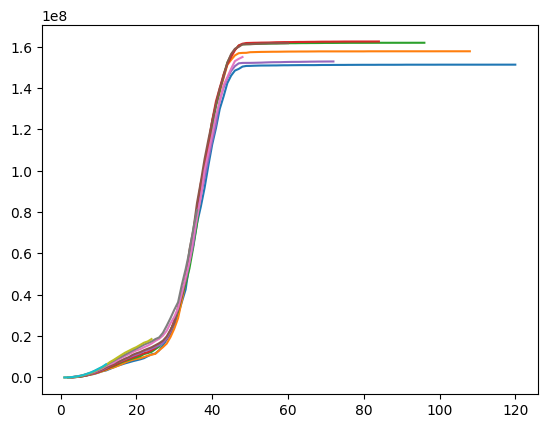

In [36]:
plt.plot(prism["Paid"].sum().grain("OYDM").to_frame(origin_as_datetime=True).T)

With claim level data, we can set a claim large loss cap or create an excess Triangle on the fly.

In [37]:
prism["Capped 100k Paid"] = cl.minimum(prism["Paid"], 100000)
prism["Excess 100k Paid"] = prism["Paid"] - prism["Capped 100k Paid"]

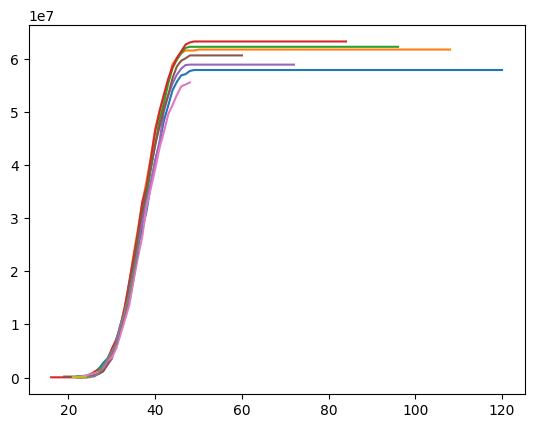

In [38]:
plt.plot(
    prism["Excess 100k Paid"].sum().grain("OYDM").to_frame(origin_as_datetime=True).T
)

### Claim-Level IBNR Estimates

Let's see how we can use the API to create claim-level IBNR estimates.  When using aggregate actuarial techniques, it really makes sense to perform the model fitting at an aggregate level.  

We use aggregate data to fit the model to generate reasonable development patterns.

In [39]:
agg_data = prism.sum()[["Paid", "reportedCount"]]
model_cl = cl.Chainladder().fit(agg_data)

With the fitted model, we are not limited to predicting ultimates at the aggregated grain. Let's predict chainladder ultimates at a claim level. Here, we are using `model_cl`, which was built using `agg_data` to make prediction on `prism`, which is claim-level data.

In [40]:
cl_ults = model_cl.predict(prism[["Paid", "reportedCount"]]).ultimate_
cl_ults

,Triangle Summary
Valuation:,2261-12
Grain:,OMDM
Shape:,"(34244, 2, 120, 1)"
Index:,"[ClaimNo, Line, Type, ClaimLiability, Limit, Deductible]"
Columns:,"[Paid, reportedCount]"


We could stop here, but let's try a Bornhuetter-Ferguson method as well. We will infer an a-priori severity from our chainladder model, `model_cl` above.

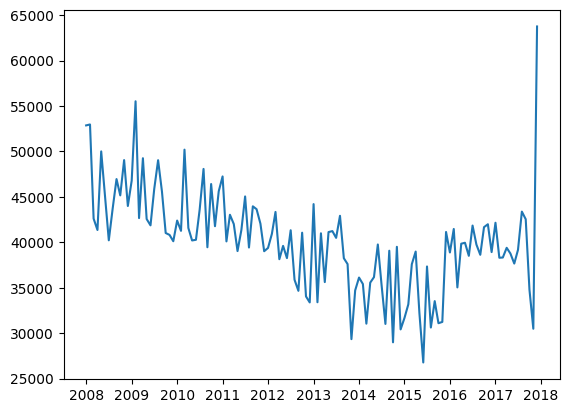

In [41]:
plt.plot(
    (model_cl.ultimate_["Paid"] / model_cl.ultimate_["reportedCount"]).to_frame(
        origin_as_datetime=True
    ),
)

40K seems a reasonable a-priori (at least for the last two years or so, between 2016 - 2017).

Now, let's fit an aggregate Bornhuetter-Ferguson model.  Like the chainladder example, we fit the model in aggregate (summing all claims) to create a stable model from which we can generate granular predictions.  We will use our Chainladder ultimate claim counts as our `sample_weight` (exposure) for the BornhuetterFerguson method.

In [42]:
paid_bf = cl.BornhuetterFerguson(apriori=40000).fit(
    X=prism["Paid"].sum().incr_to_cum(), sample_weight=cl_ults["reportedCount"].sum()
)

<BarContainer object of 10 artists>

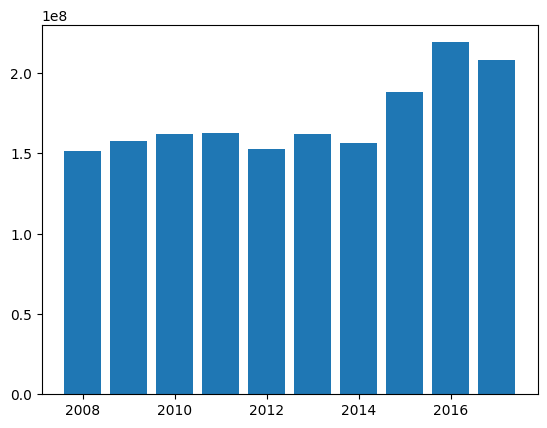

In [43]:
plt.bar(
    paid_bf.ultimate_.grain("OYDM").to_frame(origin_as_datetime=False).index.year,
    paid_bf.ultimate_.grain("OYDM").to_frame(origin_as_datetime=False)["2261-12"],
)

We can now create claim-level BornhuetterFerguson predictions using our claim-level Triangle.  Ideally, the results should tie to the aggregate results.

In [44]:
bf_ults = paid_bf.predict(
    prism["Paid"].incr_to_cum(), sample_weight=cl_ults["reportedCount"]
).ultimate_

<BarContainer object of 10 artists>

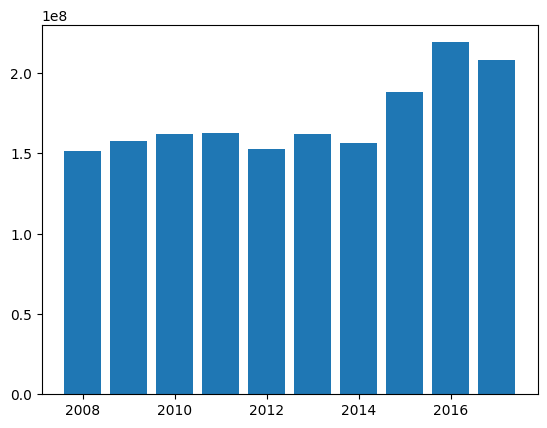

In [45]:
plt.bar(
    bf_ults.sum().grain("OYDM").to_frame(origin_as_datetime=False).index.year,
    bf_ults.sum().grain("OYDM").to_frame(origin_as_datetime=False)["2261-12"],
)